In [ ]:
#|default_exp conv

# Convolutions

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor
from torch import nn

from torch.utils.data import DataLoader,default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that.

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use a *convolution*. A convolution requires nothing more than multiplication, and addition.

### Understanding the Convolution Equations

To explain the math behind convolutions, fast.ai student Matt Kleinsmith came up with the very clever idea of showing [CNNs from different viewpoints](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c).

Here's the input:

<img alt="The image" width="75" src="images/att_00032.png">

Here's our kernel:

<img alt="The kernel" width="55" src="images/att_00033.png">

Since the filter fits in the image four times, we have four results:

<img alt="The activations" width="52" src="images/att_00034.png">

<img alt="Applying the kernel" width="366" caption="Applying the kernel" id="apply_kernel" src="images/att_00035.png">

<img alt="The equation" width="436" caption="The equation" id="eq_view" src="images/att_00036.png">

In [ ]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

In [ ]:
mpl.rcParams['figure.dpi'] = 30

In [ ]:
# show_images?

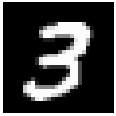

In [ ]:
im3 = x_imgs[7]
show_image(im3);

In [ ]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

We're going to call this our kernel (because that's what fancy computer vision researchers call these).

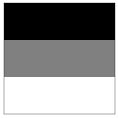

In [ ]:
show_image(top_edge, noframe=False);

The filter will take any window of size 3×3 in our images, and if we name the pixel values like this:

$$\begin{matrix} a1 & a2 & a3 \\ a4 & a5 & a6 \\ a7 & a8 & a9 \end{matrix}$$

it will return $-a1-a2-a3+a7+a8+a9$.

Show the image as set of numbers

In [ ]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [ ]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

In [ ]:
(im3[7:10,14:17] * top_edge).sum()

tensor(-2.9570)

In [ ]:
def apply_kernel(row, col, kernel): 
    return (im3[row-1:row+2,col-1:col+2] * kernel).sum()

In [ ]:
apply_kernel(4,15,top_edge)

tensor(2.9727)

<img src="images/chapter9_nopadconv.svg" id="nopad_conv" caption="Applying a kernel across a grid" alt="Applying a kernel across a grid" width="400">

In [ ]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

torch.Size([26, 26])


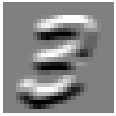

In [ ]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
print(top_edge3.shape)
show_image(top_edge3);

In [ ]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

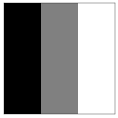

In [ ]:
show_image(left_edge, noframe=False);

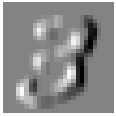

In [ ]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

<img alt="Result of applying a 3×3 kernel to a 4×4 image" width="782" caption="Result of applying a 3×3 kernel to a 4×4 image (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_ex_four_conv" src="images/att_00028.png">

### Convolutions in PyTorch

In [ ]:
import torch.nn.functional as F
import torch

What to do if you have [2 months to complete your thesis](https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo)? Use [im2col](https://hal.inria.fr/inria-00112631/).

Converting convolution into a matrix multiplication !

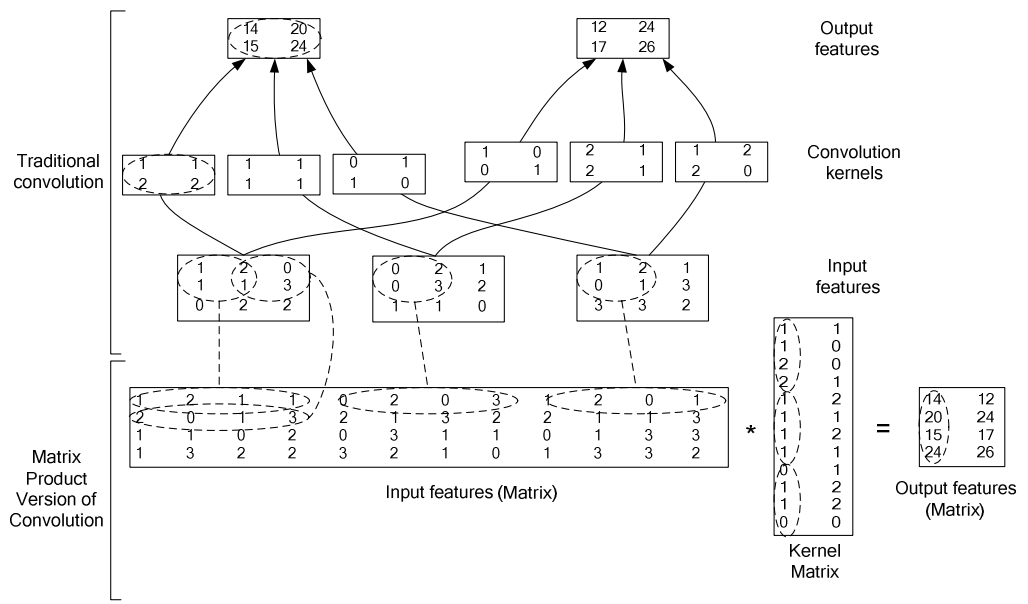

Link to a [numpy implementation](https://github.com/3outeille/CNNumpy/blob/5394f13e7ed67a808a3e39fd381f168825d65ff5/src/fast/utils.py#L360).

PyTorch implementation:
```python
F.unfold(
    input: torch.Tensor,
    kernel_size: None,
    dilation: None = 1,
    padding: None = 0,
    stride: None = 1,
) -> torch.Tensor
```
> Extracts sliding local blocks from a batched input tensor. Warning: only 4-D input tensors (batched image-like tensors) are supported.

Let's recreate the example from above.

1. Unfold the image: 

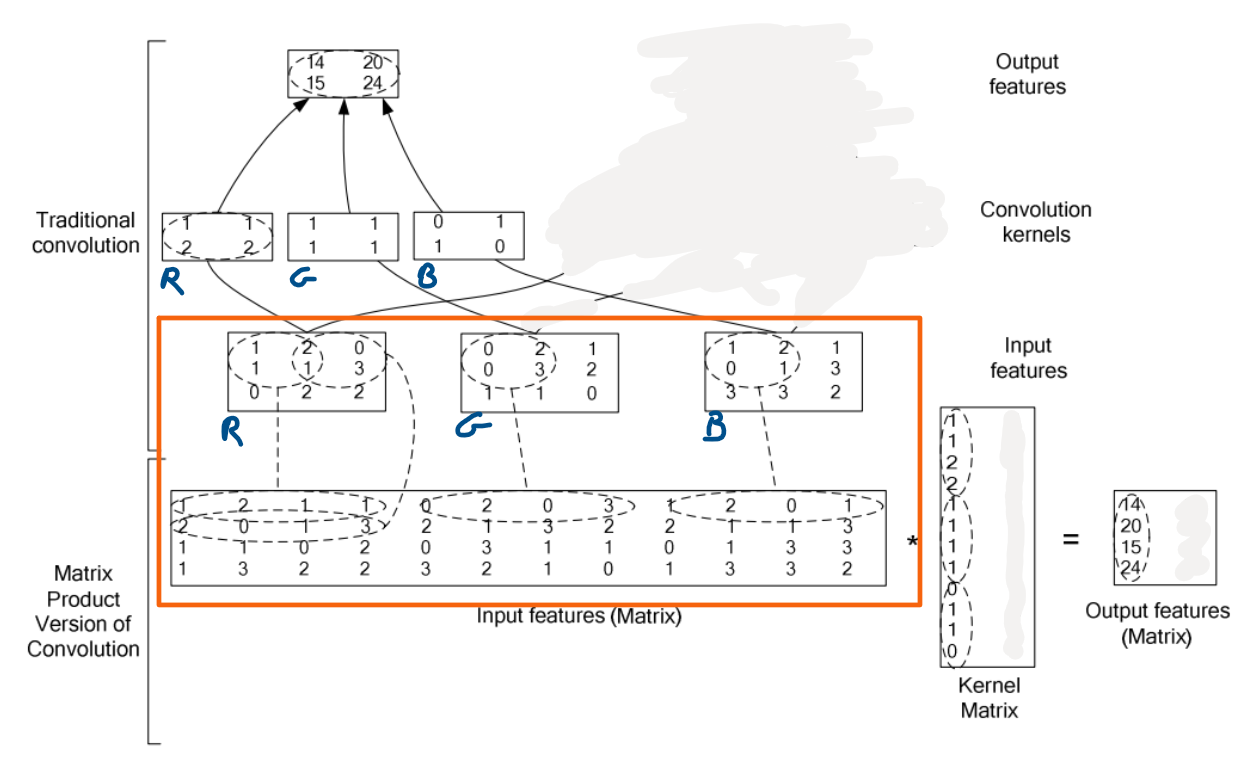

tensor([[[1., 2., 0.],
         [1., 1., 3.],
         [0., 2., 2.]],

        [[0., 2., 1.],
         [0., 3., 2.],
         [1., 1., 0.]],

        [[1., 2., 1.],
         [0., 1., 3.],
         [3., 3., 2.]]], dtype=torch.float64)

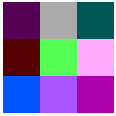

In [ ]:
im = tensor([[[1,2,0], [1,1,3], [0,2,2]],
             [[0,2,1], [0,3,2], [1,1,0]],
             [[1,2,1], [0,1,3], [3,3,2]]],
            dtype=float)
show_image(im/3);
im

In [ ]:
im_matrix = F.unfold(im[None,:,:,:],(2,2))   # F.unfold requires a 4D tensor (Batch, Channel, height, width)
print(im_matrix.shape)
im_matrix

torch.Size([1, 12, 4])


tensor([[[1., 2., 1., 1.],
         [2., 0., 1., 3.],
         [1., 1., 0., 2.],
         [1., 3., 2., 2.],
         [0., 2., 0., 3.],
         [2., 1., 3., 2.],
         [0., 3., 1., 1.],
         [3., 2., 1., 0.],
         [1., 2., 0., 1.],
         [2., 1., 1., 3.],
         [0., 1., 3., 3.],
         [1., 3., 3., 2.]]], dtype=torch.float64)

2. Adapt the kernels

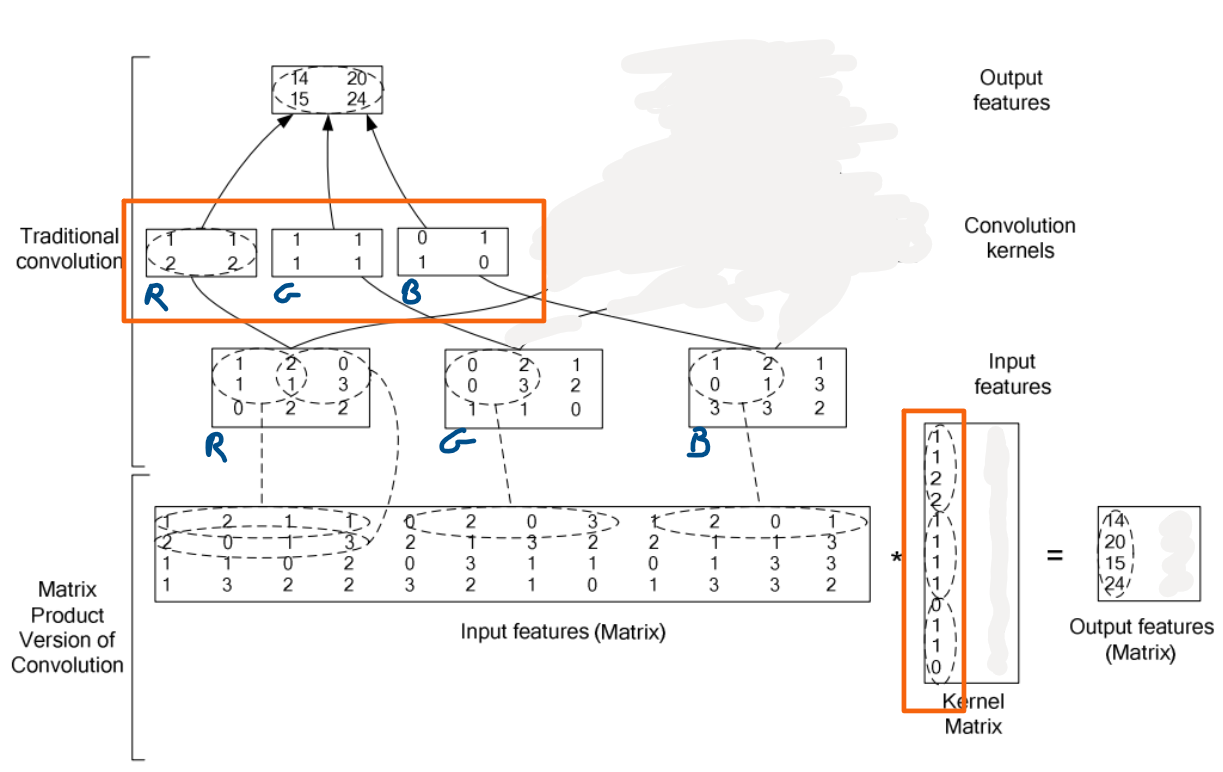

In [ ]:
cnn_k = tensor([[[1, 1], [2, 2]],
             [[1, 1], [1, 1]],
             [[0, 1], [1, 0]]],
            dtype=float)
cnn_k

tensor([[[1., 1.],
         [2., 2.]],

        [[1., 1.],
         [1., 1.]],

        [[0., 1.],
         [1., 0.]]], dtype=torch.float64)

In [ ]:
k_matrix = cnn_k.view(-1)
print(k_matrix.shape)
k_matrix

torch.Size([12])


tensor([1., 1., 2., 2., 1., 1., 1., 1., 0., 1., 1., 0.], dtype=torch.float64)

3. Get unfolded output by MatMul

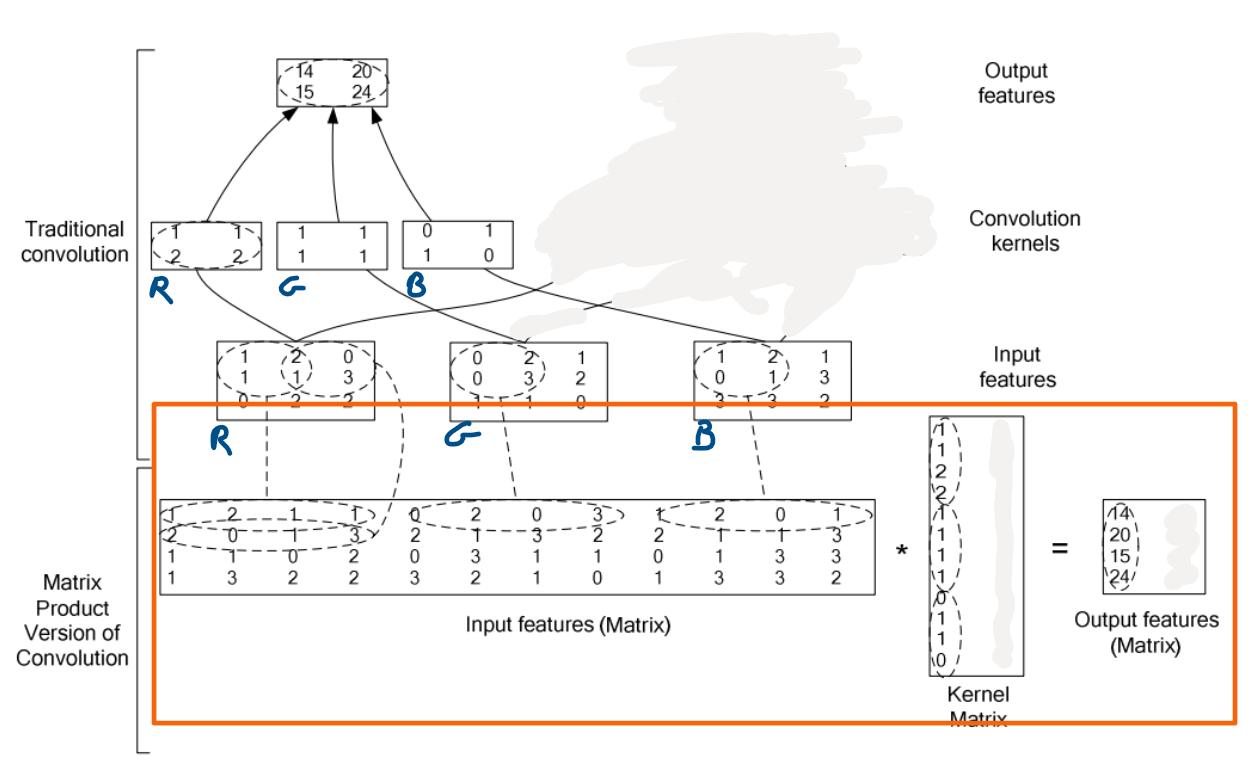

In [ ]:
output_unfolded = k_matrix @ im_matrix
output_unfolded

tensor([[14., 20., 15., 24.]], dtype=torch.float64)

Unfold the output to get an image

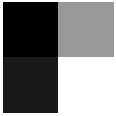

In [ ]:
output = output_unfolded.view(2,2)
show_image(output);

Now let's do the same with our B&W image or 3

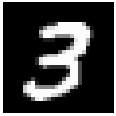

In [ ]:
show_image(im3);

1. Unfold the image

In [ ]:
inp = im3[None,None,:,:].float()
print(F.unfold(inp, (3,3)).shape)
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([1, 9, 676])


torch.Size([9, 676])

2. Flatten the kernel

In [ ]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

3. Matrix multiplication to get the unfolded output

In [ ]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

4. Reshape the image to get an image

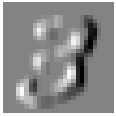

In [ ]:
out = out_unf.view(26,26)
show_image(out);

Python version

In [ ]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng]);

8.55 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


PyTorch version, using `unfold` and GPU

In [ ]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

52 µs ± 22.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Pytorch version using the `nn.conv2d`

In [ ]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

22.3 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now we do the same for a diagonal edge

In [ ]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

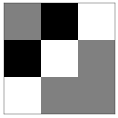

In [ ]:
show_image(diag1_edge, noframe=False);

In [ ]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

<AxesSubplot:>

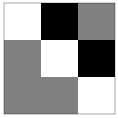

In [ ]:
show_image(diag2_edge, noframe=False)

Now let's get a batch of 16 images

In [ ]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

Stack kernels together to utilize the GPU efficiently.

In [ ]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [ ]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

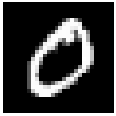

In [ ]:
img0 = xb[1,0]
show_image(img0);

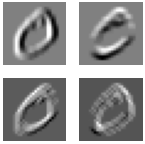

In [ ]:
show_images([batch_features[1,i] for i in range(4)])

### Strides and Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image.

<img src="images/chapter9_padconv.svg" id="pad_conv" caption="A convolution with padding" alt="A convolution with padding" width="600">

With a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map.

<img alt="A 4×4 kernel with 5×5 input and 2 pixels of padding" width="783" caption="A 4×4 kernel with 5×5 input and 2 pixels of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="four_by_five_conv" src="images/att_00029.png">

> Note: we normally use odd numbered sized kernel (see below)
>
> If we add a kernel of size `ks` by `ks` (with `ks` an odd number), the necessary padding on each side to keep the same shape is `ks//2`.

We could move over two pixels after each kernel application. This is known as a *stride-2* convolution.

It is handy as it reduces the size of the output by a factor 2 !

<img alt="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding" width="774" caption="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_by_five_conv" src="images/att_00030.png">

## Creating the CNN

In [ ]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,10, kernel_size=3, padding=1)
)

In [ ]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

The code above does not work. We cannot just put these in a sequential model, because it will not return a shape  `[None, 10]` for 10 logits for each category but a shape `[None, 10, 28, 28]` instead. That is 10 logits for each pixel.

Let's make a function that returns a Conv2d or a sequence of Conv2d followed by a ReLU activation

In [ ]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Refactoring parts of your neural networks like this makes it much less likely you'll get errors due to inconsistencies in your architectures, and makes it more obvious to the reader which parts of your layers are actually changing.

In [ ]:
simple_cnn = nn.Sequential(
    conv(1 ,nf=4),             #  1x28x28 ->  4x14x14
    conv(4 ,nf=8),             #  4x14x14 ->  8x 7x 7
    conv(8 ,nf=16),            #  8x 7x 7   -> 16x 4x 4
    conv(16,nf=16),            # 16x 4x 4  -> 16x 2x 2
    conv(16,nf=10, act=False), # 16x 2x 2  -> 10x 1x 1
    nn.Flatten(),
)

This gives us what we want !

In [ ]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [ ]:
xbb = xb.clone()
print(f"Shape input             :", xbb.shape)
for i, layer in simple_cnn.named_children():
    xbb = layer(xbb)
    print(f"Shape activation layer {i}:", xbb.shape)

Shape input             : torch.Size([16, 1, 28, 28])
Shape activation layer 0: torch.Size([16, 4, 14, 14])
Shape activation layer 1: torch.Size([16, 8, 7, 7])
Shape activation layer 2: torch.Size([16, 16, 4, 4])
Shape activation layer 3: torch.Size([16, 16, 2, 2])
Shape activation layer 4: torch.Size([16, 10, 1, 1])
Shape activation layer 5: torch.Size([16, 10])


Now we work with the full dataset

In [ ]:
x_imgs = x_train.view(-1,1,28,28)
xv_imgs = x_valid.view(-1,1,28,28)
train_ds,valid_ds = Dataset(x_imgs, y_train),Dataset(xv_imgs, y_valid)

In [ ]:
#|export
# mps for macos, cuda for linux, cpu for all if no GPU
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {def_device}")

def to_device(x, device=def_device):
    if isinstance(x, Mapping): 
        return {k:v.to(device) for k,v in x.items()}
    return type(x)(o.to(device) for o in x)

def collate_device(b): 
    return to_device(default_collate(b))

Using cuda


In [ ]:
from torch import optim

bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [ ]:
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.27919840626716613 0.9169999996185303
1 0.20451728184223175 0.9362000004768372
2 0.28302166435718534 0.9086999998092652
3 0.11761075992584229 0.9646999994277954
4 0.10751262707710266 0.967099999332428


> note that we had to add `simple_cnn` to the device (GPU)

In [ ]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.08519988915920258 0.9744999995231628
1 0.08444318981170654 0.9748999995231629
2 0.0841142550945282 0.9753999995231628
3 0.08445769736766816 0.9760999994277955
4 0.08407138373851776 0.9757999995231629


Compare the number of parameters for linear and CNN

In [ ]:
print(tensor([np.product(o.shape) for o in model.parameters()]))
print(tensor([np.product(o.shape) for o in model.parameters()]).sum())

tensor([39200,    50,   500,    10])
tensor(39760)


In [ ]:
print(tensor([np.product(o.shape) for o in simple_cnn.parameters()]))
print(tensor([np.product(o.shape) for o in simple_cnn.parameters()]).sum())

tensor([  36,    4,  288,    8, 1152,   16, 2304,   16, 1440,   10])
tensor(5274)


In [ ]:
print(tensor([o.numel() for o in simple_cnn.parameters()]))

tensor([  36,    4,  288,    8, 1152,   16, 2304,   16, 1440,   10])


```
numel(input) -> int

Returns the total number of elements in the :attr:`input` tensor.

Args:
    input (Tensor): the input tensor.
```

### Understanding Convolution Arithmetic

In an input of size `64x1x28x28` the axes are `batch,channel,height,width`. This is often represented as "Channels-first"  **`NCHW`** (where `N` refers to batch size). 

Tensorflow, on the other hand, uses `NHWC` axis order (aka "channels-last"). 

Channels-last is faster for many models, so recently it's become more common to see this as an option in PyTorch too.

We have 1 input channel, 4 output channels, and a 3×3 kernel.

In [ ]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [ ]:
conv1.bias.shape

torch.Size([4])

The **receptive field** is the area of an image that is involved in the calculation of a layer. *conv-example.xlsx* shows the calculation of two stride-2 convolutional layers using an MNIST digit. Here's what we see if we click on one of the cells in the *conv2* section, which shows the output of the second convolutional layer, and click *trace precedents*.

<img alt="Immediate precedents of conv2 layer" width="308" caption="Immediate precedents of Conv2 layer" id="preced1" src="images/att_00068.png">

The blue highlighted cells are its *precedents*—that is, the cells used to calculate its value. These cells are the corresponding 3×3 area of cells from the input layer (on the left), and the cells from the filter (on the right). Click *trace precedents* again:

<img alt="Secondary precedents of conv2 layer" width="601" caption="Secondary precedents of Conv2 layer" id="preced2" src="images/att_00069.png">

In this example, we have just two convolutional layers. We can see that a 7×7 area of cells in the input layer is used to calculate the single green cell in the Conv2 layer. This is the *receptive field*

The deeper we are in the network (specifically, the more stride-2 convs we have before a layer), the larger the receptive field for an activation in that layer.

## Color Images

A colour picture is a rank-3 tensor:

In [ ]:
from torchvision.io import read_image

In [ ]:
im = read_image('images/grizzly.jpg')
im.shape

torch.Size([3, 1000, 846])

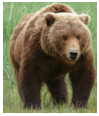

In [ ]:
show_image(im.permute(1,2,0));

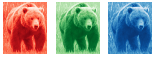

In [ ]:
_,axs = plt.subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): show_image(255-bear, ax=ax, cmap=color)

<img src="images/chapter9_rgbconv.svg" id="rgbconv" caption="Convolution over an RGB image" alt="Convolution over an RGB image" width="550">

These are then all added together, to produce a single number, for each grid location, for each output feature.

<img src="images/chapter9_rgb_conv_stack.svg" id="rgbconv2" caption="Adding the RGB filters" alt="Adding the RGB filters" width="500">

We have `ch_out` filters like this, so in the end, the result of our convolutional layer will be a batch of images with `ch_out` channels.

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()